In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
import requests
from PIL import Image
from io import BytesIO

from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail
from nba_api.stats.static.players import find_players_by_full_name


In [2]:
import time, tqdm
from adjustText import adjust_text

In [3]:
player_id = find_players_by_full_name('Trae Young')[0]['id']

player_data = ShotChartDetail(season_nullable='2019-20', team_id=0, player_id=player_id, context_measure_simple='FGA')

In [4]:
player_df = player_data.get_data_frames()[0]

league_avg = player_data.get_data_frames()[1]
player_df.LOC_X = -player_df.LOC_X

In [3]:
import random
from matplotlib.patches import Circle, Rectangle, Arc

# Amazing function by Bradley Fay for plotting the nba court
# source: https://github.com/bradleyfay/py-Goldsberry/blob/master/docs/Visualizing%20NBA%20Shots%20with%20py-Goldsberry.ipynb
def draw_court(ax=None, color='black', lw=2, background_color="#EBEBE8", outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False, zorder=0)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False, zorder=0)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False, zorder=0)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed', zorder=0)
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color, zorder=0)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 138, linewidth=lw,
                               color=color, zorder=0)
    corner_three_b = Rectangle((220, -47.5), 0, 138, linewidth=lw, color=color, zorder=0)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22.13, theta2=157.87, linewidth=lw,
                    color=color, zorder=0)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color, zorder=0)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color, zorder=0)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]
    
    # Draw the half court line, baseline and side out bound lines
    outer_lines = Rectangle((-249, -48), 498, 470, linewidth=lw,
                            color=color, fill=None)
    court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

In [4]:
from collections import Counter
import operator
def create_bins(data_frame, bin_number_x = 30, bin_number_y=300 / (500.0 / 30.0), league_average = None,
                width = 500, height = 300, norm_x = 250, norm_y = 48):
    """
    Method which creates bins the dataset into squared grid. This is used so that plot looks nicer than the raw
    locations plot. Along with binning the data, the percentages per zones and for each bin are calculated here
    and added to the copy of data_frame object so they can be used for plotting later.

    :return: Returns the copied  data_frame pandas DataFrame object with additional info about the shots.
    """
    # Binned x and y coordinates
    x_bins, y_bins = [], []
    # Copying the dataset to add more data
    copied_df = data_frame.copy()
    # Keys are basically x_bin and y_bin
    keys = []
    # Counter of shots and shots made per locations
    location_counts, location_made = Counter(), Counter()
    # be found

    # Size of elements in bin, they should be the same
    bin_size_x = float(width) / float(bin_number_x)
    bin_size_y = float(height) / float(bin_number_y)
    # List for locations of shots
    locations_annotated = []
    # Counter of shots and shots made per zone
    zones_counts, zones_made = Counter(), Counter()

    # Maximum size of an element in one bin
    max_size = int((int(bin_size_x) - 1) * (int(bin_size_y) - 1))

    # Keys that are in restricted area will be stored here, this will be used for finding maximum number of shots
    restricted_area_keys = []

    # Dictionary which will determine the color of marker in bin
    percentage_color_dict = {}

    for i in range(len(data_frame)):

        # Row from data frame
        row = data_frame.iloc[i]

        x_shot_orig, y_shot_orig = row.LOC_X, row.LOC_Y

        # Normalize
        x_shot = x_shot_orig + norm_x  # to put minimum to zero
        y_shot = y_shot_orig + norm_y  # to put minimum to zero

        # bin_index = (x_shot / w) * bin_size
        curr_x_bin = 0 if x_shot == 0 else int((x_shot / float(width)) * bin_number_x)
        curr_y_bin = 0 if y_shot == 0 else int((y_shot / float(height)) * bin_number_y)

        # Key for dicts
        key = (curr_x_bin, curr_y_bin)

        if row.SHOT_ZONE_BASIC == "Restricted Area":
            restricted_area_keys.append(key)

        # Counting number of shots made and shots shot
        keys.append(key)
        location_counts[key] += 1
        location_made[key] += row.SHOT_MADE_FLAG

        basic_shot_zone, shot_zone_area = row.SHOT_ZONE_BASIC, row.SHOT_ZONE_AREA
        zone_dist = row.SHOT_ZONE_RANGE

        area_code = shot_zone_area.split("(")[1].split(")")[0]
        if "3" in basic_shot_zone:
            locations_annotated.append("3" + area_code)
        elif "Paint" in basic_shot_zone:
            locations_annotated.append("P" + area_code + zone_dist[0])
        elif "Mid" in basic_shot_zone:
            locations_annotated.append("M" + area_code + zone_dist[0])
        else:
            locations_annotated.append("R" + area_code)

        # Creating key for zones
        zone_key = (basic_shot_zone, shot_zone_area, zone_dist)

        # Counting the occurences based on both bin_key and zone_key, because of that we have dict in dict
        if key in percentage_color_dict:
            if zone_key in percentage_color_dict[key]:
                percentage_color_dict[key][zone_key] = percentage_color_dict[key][zone_key] + 1
            else:
                percentage_color_dict[key][zone_key] = 1
        else:
            percentage_color_dict[key] = {}
            percentage_color_dict[key][zone_key] = 1

        zones_counts[zone_key] += 1

        if row.SHOT_MADE_FLAG:
            zones_made[zone_key] += 1

    shot_locations_percentage = []  # percentage in given bin
    shot_locations_counts = []
    raw_counts = []
    # List which contains comparison for each shot with league average in that zone
    shot_comparison = []
    # List which contains comparison of player's shooting in zone vs league average
    per_zone_comparison = []
    per_zone_percentage = []

    # Finding the maximal number of shots from data
    non_ra = []
    for key in location_counts:
        if key not in restricted_area_keys:
            if location_counts[key] not in non_ra:
                non_ra.append(location_counts[key])

    sorted_non_ra = sorted(non_ra)
    max_out_of_restricted = float(sorted_non_ra[-1])

    for j in range(len(data_frame)):
        key = keys[j]
        x_bin, y_bin = key[0], key[1]
        shot_percent = float(location_made[key]) / location_counts[key]
        # shot_percent = np.clip(shot_percent, 0.3, 0.7)
        shot_locations_percentage.append(shot_percent * 100)
        if league_average is not None:
            # Getting info about zone
            # We are getting that info from
            per_zone_counter_from_percentage_color_dict = percentage_color_dict[key]
            zone_key = max(per_zone_counter_from_percentage_color_dict.items(),
                           key=operator.itemgetter(1))[0]

            shot_zone_basic = zone_key[0]
            shot_zone_area = zone_key[1]
            distance = zone_key[2]

            # Calculating the percentage in current zone
            zone_percent = 0.0 if zone_key not in zones_made else float(zones_made[zone_key]) / \
                                                                  float(zones_counts[zone_key])

            # Retrieving league average percentage for current zone
            avg_percentage = league_average.loc[
                (league_average.SHOT_ZONE_BASIC == shot_zone_basic) &
                (league_average.SHOT_ZONE_AREA == shot_zone_area) &
                (league_average.SHOT_ZONE_RANGE == distance)].FG_PCT.iloc[
                0
            ]
            # Comparison of league average and each shot
            shot_comparison.append(np.clip((shot_percent - avg_percentage) * 100, -10, 10))
            # Comparison of zone and league average
            per_zone_comparison.append(np.clip((zone_percent - avg_percentage) * 100, -10, 10))
            # Percentage of shot in current zone, kinda inaccurate info, good for some other type of plot
            per_zone_percentage.append(zone_percent * 100)

        # Calculating value to which the markers will be scaled later on
        # The data in restricted is scaled to maximum out of restricted area, because players usually have a lot
        # more shots in restricted area
        value_to_scale = max_out_of_restricted if location_counts[key] > max_out_of_restricted else \
            location_counts[key]
        # Storing the data into a list
        shot_locations_counts.append((float(value_to_scale) / max_out_of_restricted) * max_size)

        # Count of shots per bin
        raw_counts.append(location_counts[key])

        # Middle of current and next bin is where we will place the marker in real coordinates
        unbinned_x = ((x_bin * float(width)) / bin_number_x + (
                (x_bin + 1) * float(width)) / bin_number_x) / 2 - norm_x
        unbinned_y = ((y_bin * float(height)) / bin_number_y + (
                (y_bin + 1) * float(height)) / bin_number_y) / 2 - norm_y

        # Adding binned locations
        x_bins.append(unbinned_x)
        y_bins.append(unbinned_y)

    # Binned locations
    copied_df['BIN_LOC_X'] = x_bins
    copied_df['BIN_LOC_Y'] = y_bins
    # Percentage comparison with league averages
    if league_average is not None:
        # Comparison of each shot with league average for that zone
        copied_df['PCT_LEAGUE_AVG_COMPARISON'] = shot_comparison
        # Comparison of each zone with league average for that zone
        copied_df['PCT_LEAGUE_COMPARISON_ZONE'] = per_zone_comparison
    # Percentage of shots for that location
    copied_df['LOC_PERCENTAGE'] = shot_locations_percentage
    # Percentage of whole zone (not in comparison with league average)
    copied_df['LOC_ZONE_PERCENTAGE'] = per_zone_percentage
    # Scaled count of shots and count of shots per bin
    copied_df['LOC_COUNTS'] = shot_locations_counts
    copied_df['LOC_RAW_COUNTS'] = raw_counts

    return copied_df

In [5]:
text_location_mapping = {
    ('Right Corner 3', 'Right Side(R)', '24+ ft.'): (-235, 50),
    ('Left Corner 3', 'Left Side(L)', '24+ ft.'): (235, 50),
    ('Above the Break 3', 'Center(C)', '24+ ft.'): (0, 260),
    ('Above the Break 3', 'Left Side Center(LC)', '24+ ft.'): (155, 230),
    ('Above the Break 3', 'Right Side Center(RC)', '24+ ft.'): (-155, 230),
    ('Restricted Area', 'Center(C)', 'Less Than 8 ft.'): (0, 20),
    ('Mid-Range', 'Center(C)', '16-24 ft.'): (0, 190),
    ('Mid-Range', 'Center(C)', '8-16 ft.') : (0, 150),  # merge prethodni
    ('Mid-Range', 'Left Side Center(LC)', '16-24 ft.'): (110, 180),
    ('Mid-Range', 'Right Side Center(RC)', '16-24 ft.'): (-110, 180),
    ('In The Paint (Non-RA)', 'Center(C)', '8-16 ft.'): (0, 110),
    ('In The Paint (Non-RA)', 'Center(C)', 'Less Than 8 ft.'): (0, 60),
    ('In The Paint (Non-RA)', 'Left Side(L)', '8-16 ft.'): (70, 80),  # merge s ovim dole
    ('Mid-Range', 'Left Side(L)', '8-16 ft.'): (120, 50),
    ('In The Paint (Non-RA)', 'Right Side(R)', '8-16 ft.'): (-70, 80),  # merge s ovim dole
    ('Mid-Range', 'Right Side(R)', '8-16 ft.'): (-120, 50),
    ('Mid-Range', 'Left Side(L)', '16-24 ft.'): (190, 50),
    ('Mid-Range', 'Right Side(R)', '16-24 ft.'): (-190, 50),
}

In [6]:
import matplotlib.path as mpath
from matplotlib.colors import colorConverter
def get_smooth_square():
    """
    Creates marker which represents smooth square.

    :return: new matplotlib.path.Path instance
    """
    marker = np.array([[-0.8, 1.0],
                       [-1.0, 0.8],
                       [-1.0, -0.8],
                       [-0.8, -1.0],
                       [0.8, -1.0],
                       [1.0, -0.8],
                       [1.0, 0.8],
                       [0.8, 1.0],
                       [-0.8, 1.0]])

    return mpath.Path(marker, closed=True)

def plot_shotchart(original_df, data_frame, title, mode='light', plot_text=False):
    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots(figsize=(12, 12))
    # colors_dict = {0:'red', 1:'green'}
    cmap = sns.blend_palette(colors=["#4159E1", "#B0E0E6", "#FFFF99","#EF3330", "#AB2020"], as_cmap=True)

    
    # LOC_PERCENTAGE -> total perc
    # PCT_LEAGUE_AVG_COMPARISON -> comparison per bins
    # PCT_LEAGUE_COMPARISON_ZONE -> comparison per zones only
    # LOC_X, LOC_Y -> real locs
    # BIN_LOC_X, BIN_LOC_Y -> binned locations
    marker = get_smooth_square()
    edge_color = colorConverter.to_rgba('black', alpha=.5)
    dropped_dups = data_frame.drop_duplicates(subset=['BIN_LOC_X', 'BIN_LOC_Y'], keep='first')
    paths = ax.scatter(
        x=dropped_dups.BIN_LOC_X,
        y=dropped_dups.BIN_LOC_Y,
        marker=marker,
        s=dropped_dups.LOC_COUNTS * 2,
        c=dropped_dups.PCT_LEAGUE_COMPARISON_ZONE,
        cmap=cmap,
        edgecolors='black',
    )

    if mode == 'dark':
        background_color="#000000"
        font_color="#E8E8FF"
    else:
        background_color="#EBEBE8"
        font_color = "#454545"
    # Frequency
    

    ax.text(x=-240, y=360, s="Less\nFrequent", color=font_color, fontsize=12)
    ax.scatter(x=-218, y=377, s=20 * 1 * 2.5, marker=marker, c=font_color)
    ax.scatter(x=-205, y=377, s=20 * 3 * 2.5, marker=marker, c=font_color)
    ax.scatter(x=-190, y=377, s=20 * 6 * 2.5, marker=marker, c=font_color)
    ax.scatter(x=-171, y=377, s=20 * 9 * 2.5, marker=marker, c=font_color)
    ax.scatter(x=-151, y=377, s=20 * 11 * 2.5, marker=marker, c=font_color)
    ax.text(x=-153, y=360, s="      More\nFrequent", color=font_color, fontsize=12)


    # Efficiency

    ax.text(x=164, y=400, s="Comparison with\nleague average percentage", color=font_color, fontsize=12, ha='center')
    ax.text(x=95, y=360, s="Below\nAverage", color=font_color, fontsize=12)
    ax.scatter(x=130, y=377, s=550, marker=marker, c="#4159E1", edgecolors='black')
    ax.scatter(x=147, y=377, s=550, marker=marker, c="#B0E0E6", edgecolors='black')
    ax.scatter(x=164, y=377, s=550, marker=marker, c="#FFFF99", edgecolors='black')
    ax.scatter(x=181, y=377, s=550, marker=marker, c="#EF3330", edgecolors='black')
    ax.scatter(x=198, y=377, s=550, marker=marker, c="#AB2020", edgecolors='black')
    ax.text(x=201, y=360, s="   Above\nAverage", color=font_color, fontsize=12)
    
    df_by_zone_sum = original_df.groupby(by=['SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE']).sum()
    df_by_zone_sum.loc[:, 'ZONE_PCT'] = (df_by_zone_sum.SHOT_MADE_FLAG / df_by_zone_sum.SHOT_ATTEMPTED_FLAG) * 100
    df_by_zone_median = original_df.groupby(by=['SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE']).median()
    for index in range(len(df_by_zone_median)):
        loc_x = df_by_zone_median.iloc[index].LOC_X
        loc_y = df_by_zone_median.iloc[index].LOC_Y
        zone_percentage = df_by_zone_sum.iloc[index].ZONE_PCT
        zone_shots_made = df_by_zone_sum.iloc[index].SHOT_MADE_FLAG
        zone_shots_attempted = df_by_zone_sum.iloc[index].SHOT_ATTEMPTED_FLAG
        if df_by_zone_median.iloc[index].name not in text_location_mapping:
            continue
        x, y = text_location_mapping[df_by_zone_median.iloc[index].name]
        if zone_shots_attempted < 2:
            continue
        ax.text(x=x, y=y, s=f"{zone_percentage:.2f}%", ha='center', c='black',
               bbox={'facecolor': '#F3F3A9', 'alpha': 0.75, 'edgecolor': 'black'})
    # Removing ticks
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.grid(False)
    ax.set_frame_on(False)
    
    team_id = dropped_dups.iloc[0].TEAM_ID
    player_id = dropped_dups.iloc[0].PLAYER_ID
    url = f"https://ak-static.cms.nba.com/wp-content/uploads/headshots/nba/{team_id}/2019/260x190/{player_id}.png"
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))

    ax.imshow(img, extent=(132, 252, -48, 40))
    
    
    ax.set_facecolor(background_color)
    fig.set_facecolor(background_color)

    # Title
    plt.title(title, size=24)
    
    # Drawing court
    draw_court(ax=ax,outer_lines=True, lw=3, color='black')
    ax.set_xlim(-252,252)
    ax.set_ylim(-65,423)

    return dropped_dups

In [7]:
def plot_raw_shotchart(data_frame, title, mode="dark", assist_df=None, image_name=None):
    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots(figsize=(12, 12))
    green = '#45B056'
    red = '#B04556'
    
    # ('Mid-Range', 'Right Side Center(RC)', '16-24 ft.')
    bball_gray = '#312f30'
    bball_white = '#dddee0'
    bball_orange = '#f87c24'
    bball_light_orange = '#fbaf7b'
    
    data_frame = data_frame.loc[data_frame.SHOT_ZONE_BASIC != 'Backcourt']
    original_df = data_frame
    
    made_shots = data_frame.loc[data_frame.SHOT_MADE_FLAG == 1]
    missed_shots = data_frame.loc[data_frame.SHOT_MADE_FLAG == 0]
    
    paths = ax.scatter(
        x=missed_shots.LOC_X,
        y=missed_shots.LOC_Y,
        marker='o',
        c=bball_white,
        s=180,
        alpha=0.8,
        lw=1,
        edgecolors='black',
        label='Missed Shots'
    )
    
    paths = ax.scatter(
        x=made_shots.LOC_X,
        y=made_shots.LOC_Y,
        marker='o',
        c=bball_orange,
        s=180,
        alpha=0.8,
        lw=1,
        edgecolors='black',
        label='Made Shots'
    )
    
    if mode == 'dark':
        background_color="#363F48"
        font_color="#E8E8FF"
    else:
        background_color="#EBEBE8"
        font_color = "#454545"
    
    """texts = []
    for index in range(len(data_frame)):
        item = data_frame.iloc[index]
        texts.append(plt.text(x=item.LOC_X, y=item.LOC_Y, s=item.ACTION_TYPE, fontsize=10, ha='center', va='center',
               bbox={'facecolor': '#EEEEEE', 'alpha': 0.75, 'edgecolor': 'black'}, zorder=0))
    """
    
    df_by_zone_sum = original_df.groupby(by=['SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE']).sum()
    df_by_zone_sum.loc[:, 'ZONE_PCT'] = (df_by_zone_sum.SHOT_MADE_FLAG / df_by_zone_sum.SHOT_ATTEMPTED_FLAG) * 100
    df_by_zone_median = original_df.groupby(by=['SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE']).median()
    for index in range(len(df_by_zone_median)):
        loc_x = df_by_zone_median.iloc[index].LOC_X
        loc_y = df_by_zone_median.iloc[index].LOC_Y
        zone_percentage = df_by_zone_sum.iloc[index].ZONE_PCT
        zone_shots_made = df_by_zone_sum.iloc[index].SHOT_MADE_FLAG
        zone_shots_attempted = df_by_zone_sum.iloc[index].SHOT_ATTEMPTED_FLAG
        if df_by_zone_median.iloc[index].name not in text_location_mapping:
            continue
        x, y = text_location_mapping[df_by_zone_median.iloc[index].name]
        if zone_shots_attempted < 5:
            continue
        ax.text(x=x, y=y, s=f"{int(zone_shots_made)}/{int(zone_shots_attempted)}", ha='center', c='black',
               bbox={'facecolor': '#F3F3A9', 'alpha': 0.75, 'edgecolor': 'black'})
    
    # Changing court color
    #ax.set_facecolor('#FFFAFA')
    
    ax.set_facecolor(bball_gray)
    fig.set_facecolor(bball_gray)
    ax.set_frame_on(False)
    
    # Legend
    legend = ax.legend()
    frame = legend.get_frame()
    frame.set_facecolor(bball_gray)
    frame.set_linewidth(2)
    frame.set_edgecolor(bball_light_orange)
    for text in legend.get_texts():
        text.set_color(bball_light_orange)

    # Removing ticks
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    #ax.set_xticks(range(-250, 255, 10))
    #ax.set_xticklabels(range(-250, 255, 10), rotation=90)
    #ax.set_yticks(range(0, 300, 10))
    #ax.set_yticklabels(range(0, 300, 10))
    ax.grid(False)
    
    team_id = made_shots.iloc[0].TEAM_ID
    player_id = made_shots.iloc[0].PLAYER_ID
    url = f"https://ak-static.cms.nba.com/wp-content/uploads/headshots/nba/{team_id}/2019/260x190/{player_id}.png"
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))

    ax.imshow(img, extent=(132, 252, -48, 40))
    
    # Title
    ax.set_title(title, size=20, color=bball_light_orange)
    
    # Drawing court
    draw_court(ax=ax,outer_lines=True, lw=3, color=bball_light_orange)
    ax.set_xlim(-251,251)
    ax.set_ylim(-65,423)
    
    #adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k'), expand_points=(1.25, 1.25), expand_text=(1.25, 1.25), force_text=(0.5, 0.9))
    
    if image_name:
        fig.savefig(image_name, bbox_inches='tight')

In [10]:
player_id = find_players_by_full_name('Trae Young')[0]['id']

player_data = ShotChartDetail(season_nullable='2019-20', team_id=0, player_id=player_id, context_measure_simple='FGA')

player_df = player_data.get_data_frames()[0]

league_avg = player_data.get_data_frames()[1]
player_df.LOC_X = -player_df.LOC_X

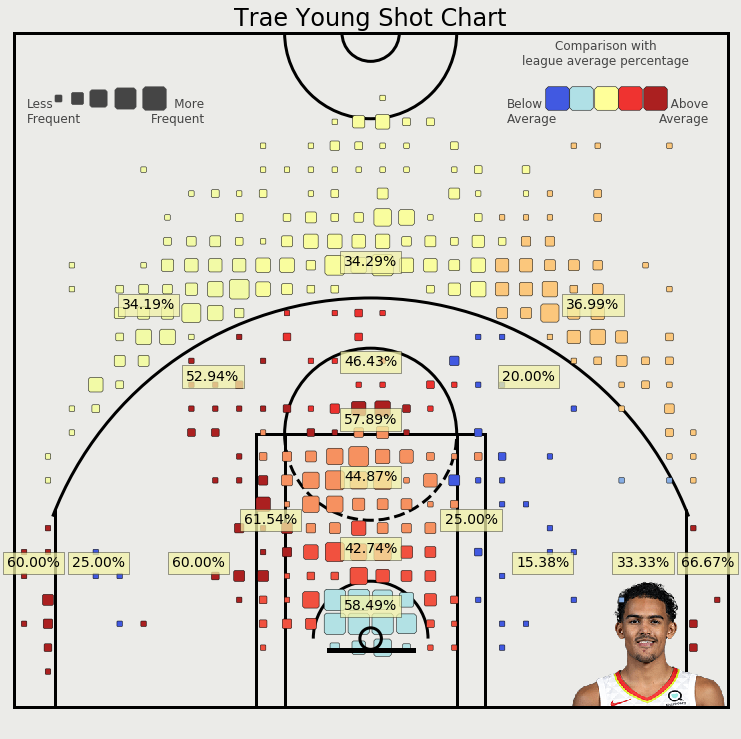

In [10]:
#player_df = player_df.loc[player_df.SHOT_DISTANCE < 40]

binned_df = create_bins(data_frame=player_df, league_average=league_avg)

_ = plot_shotchart(original_df=player_df, data_frame=binned_df, title="Trae Young Shot Chart", mode='light', plot_text=False)

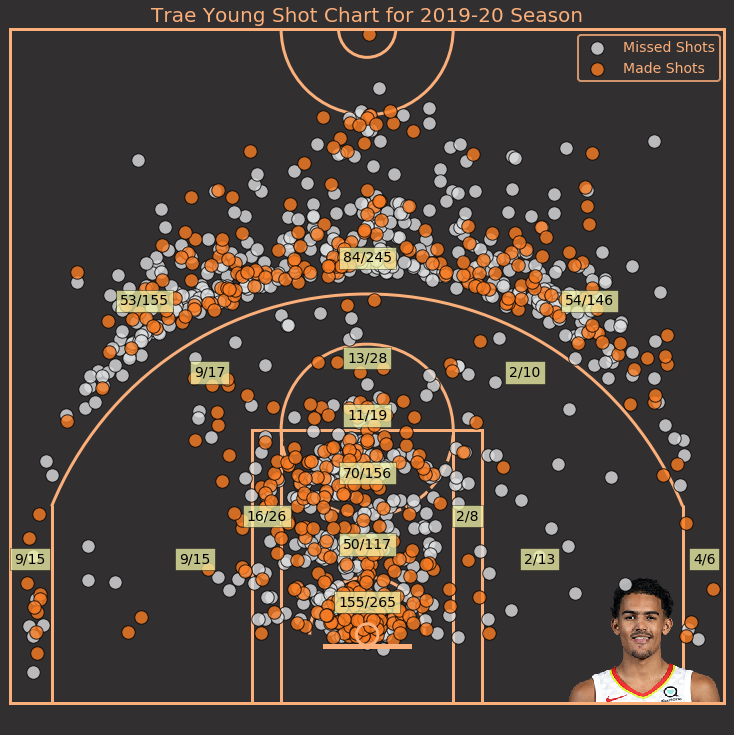

In [11]:
plot_raw_shotchart(player_df, title="Trae Young Shot Chart for 2019-20 Season", mode='light')

In [12]:
player_id = find_players_by_full_name('Damian Lillard')[0]['id']
player_data = ShotChartDetail(season_nullable='2019-20', team_id=0, player_id=player_id, context_measure_simple='FGA')

player_df = player_data.get_data_frames()[0]

league_avg = player_data.get_data_frames()[1]
player_df.LOC_X = -player_df.LOC_X

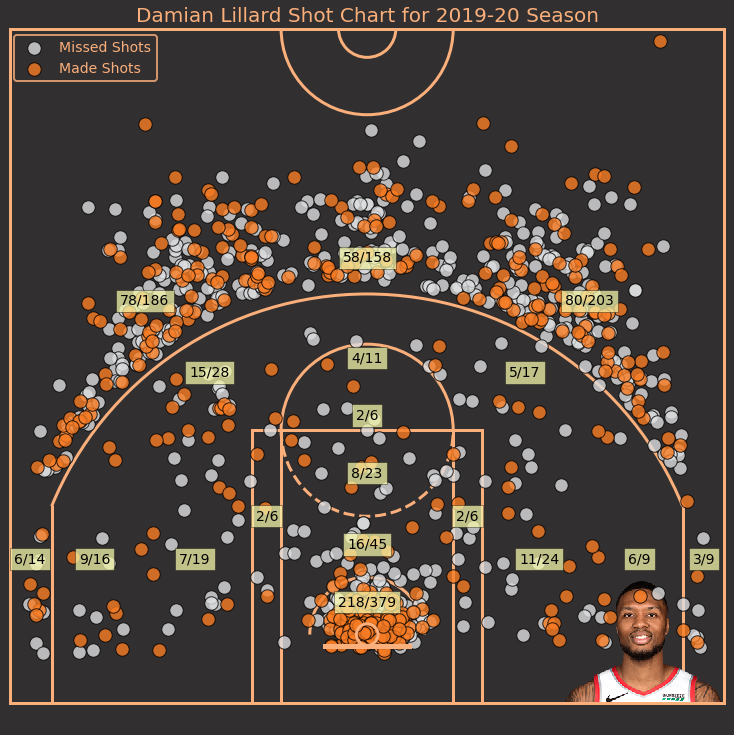

In [13]:
plot_raw_shotchart(player_df, title="Damian Lillard Shot Chart for 2019-20 Season", mode='light')

Protrcat po svim shotchartovima od ovih top N šutera i onda splotat broj trica i njihovu udaljenost

In [8]:
from nba_api.stats.endpoints.leaguedashplayerstats import LeagueDashPlayerStats

In [9]:
league_stats = LeagueDashPlayerStats()

In [10]:
league_df = league_stats.get_data_frames()[0]

In [17]:
top_three = league_df.sort_values(by='FG3M', ascending=False).iloc[:150]

In [18]:
top_three.head()

,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,AGE,GP,W,L,W_PCT,MIN,...,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,CFID,CFPARAMS
213,201935,James Harden,1610612745,HOU,30.0,61,39,22,0.639,2241.183333,...,511,511,2,1,24,1,28,6,5,"201935,1610612745"
51,1627741,Buddy Hield,1610612758,SAC,27.0,64,28,36,0.438,2044.840000,...,453,465,161,22,366,40,136,28,5,"1627741,1610612758"
138,1629130,Duncan Robinson,1610612748,MIA,25.0,65,41,24,0.631,1949.241667,...,199,493,230,77,12,130,180,28,5,"1629130,1610612748"
87,203081,Damian Lillard,1610612757,POR,29.0,58,27,31,0.466,2139.921667,...,507,317,8,5,106,8,33,16,5,"203081,1610612757"
124,1628984,Devonte' Graham,1610612766,CHA,25.0,63,23,40,0.365,2211.231667,...,402,369,27,33,474,34,31,28,5,"1628984,1610612766"


In [55]:
distances = []
medians = []
for index in tqdm.tqdm(range(len(top_three))):
    item = top_three.iloc[index]
    shotchart = ShotChartDetail(team_id=0, player_id=item.PLAYER_ID, season_nullable='2019-20', context_measure_simple='FGA')
    shot_df = shotchart.get_data_frames()[0]
    shot_df = shot_df.loc[shot_df.SHOT_TYPE == '3PT Field Goal']
    shot_df = shot_df.loc[shot_df.SHOT_DISTANCE <= 47]  # only half court shots
    mean_dist = shot_df.SHOT_DISTANCE.mean()
    distances.append(mean_dist)
    medians.append(shot_df.SHOT_DISTANCE.median())
    time.sleep(0.7)



  0%|                                                                                                                                                                                        | 0/60 [00:00<?, ?it/s]

  2%|██▉                                                                                                                                                                             | 1/60 [00:03<03:21,  3.42s/it]

  3%|█████▊                                                                                                                                                                          | 2/60 [00:06<03:11,  3.30s/it]

  5%|████████▊                                                                                                                                                                       | 3/60 [00:09<02:56,  3.10s/it]

  7%|███████████▋                                                                                                                             

In [56]:
top_three.loc[:, 'MEAN_3PT_DISTANCE'] = distances

In [58]:
top_three.loc[:, 'MEDIAN_3PT_DISTANCE'] = medians

In [59]:
np_dist = np.array(distances)

In [60]:
meter_dist = np_dist * 0.3048

In [61]:
top_three.loc[:, 'MEAN_3PT_DISTANCE_M'] = meter_dist

In [62]:
top_three.loc[:, 'MEDIAN_3PT_DISTANCE_M'] = np.array(medians) * 0.3048

In [63]:
top_three.to_csv('three_pt_distance.csv')

In [15]:
top_three = pd.read_csv('three_pt_distance.csv')

In [16]:
team_colors = {
    'IND': "#FDBB30",
    'HOU': "#CE1141",
    'SAC': "#5A2D81",
    'MIA': "#DB3EB1",
    'POR': "#FFFFFF",
    'CHA': "#00788C",
    'ATL': "#C1D32F",
    'WAS': "#002B5C",
    'UTA': "#F9A01B",
    'DAL': "#00538C",
    'CHI': "#CE1141",
    'MIN': "#78BE20",
    'LAL': "#552583",
    'DET': "#1D42BA",
    'BKN': "#000000",
    "TOR": "#B4975A",
    "NOP": "#0C2340",
}

In [17]:
top_three = top_three.sort_values(by='FG3M', ascending=False)

In [18]:
top_scorers = top_three.iloc[:10]

In [19]:
top_distances = top_three.sort_values(by='MEAN_3PT_DISTANCE_M', ascending=False).iloc[:10]
worse_distances = top_three.sort_values(by='MEAN_3PT_DISTANCE_M').iloc[:7]

In [20]:
all_dfs = pd.concat([top_scorers, top_distances, worse_distances], ignore_index=True)

In [21]:
all_dfs = all_dfs.drop_duplicates()

In [22]:
non_marked = top_three.loc[~top_three.PLAYER_ID.isin(all_dfs.PLAYER_ID.tolist())]

In [23]:
colors = []
for index in range(len(all_dfs)):
    item = all_dfs.iloc[index]
    colors.append(team_colors[item.TEAM_ABBREVIATION])

In [24]:
bball_gray = '#312f30'
bball_white = '#dddee0'
bball_orange = '#f87c24'
bball_light_orange = '#fbaf7b'

12

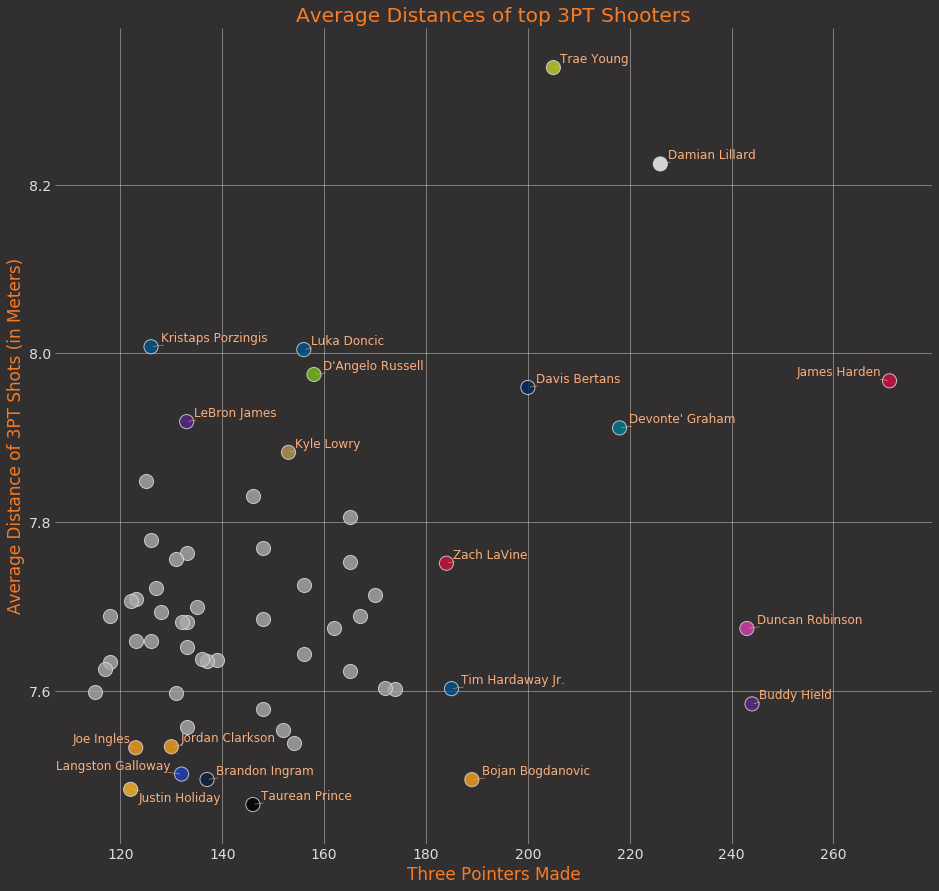

In [25]:
fig, ax = plt.subplots(figsize=(14, 14))

ax.scatter(x=non_marked.FG3M, y=non_marked.MEAN_3PT_DISTANCE_M, s=200, edgecolors=bball_white, lw=1, color='#ABABAB', alpha=0.8)
ax.scatter(x=all_dfs.FG3M, y=all_dfs.MEAN_3PT_DISTANCE_M, s=200, edgecolors=bball_white, lw=1, color=colors, alpha=0.8)
ax.set_xlabel("Three Pointers Made", color=bball_orange)
ax.set_ylabel("Average Distance of 3PT Shots (in Meters)", color=bball_orange)
ax.set_title("Average Distances of top 3PT Shooters", color=bball_orange)

ax.set_facecolor(bball_gray)
fig.set_facecolor(bball_gray)
ax.set_frame_on(False)
ticks = ax.get_xticklabels()
for tick in ticks:
    tick.set_color(bball_white)
ticks = ax.get_yticklabels()
for tick in ticks:
    tick.set_color(bball_white)

ax.grid(b=True, alpha=0.5)
texts = []
added = []
for index in range(len(all_dfs)):
    item = all_dfs.iloc[index]
    if item.PLAYER_NAME in added:
        continue
    texts.append(ax.text(x=item.FG3M, y=item.MEAN_3PT_DISTANCE_M, s=item.PLAYER_NAME, size=12, color=bball_light_orange))
    added.append(item.PLAYER_NAME)
    
adjust_text(texts, arrowprops=dict(arrowstyle='-', color=bball_light_orange), expand_points=(1.2, 1.3))

12

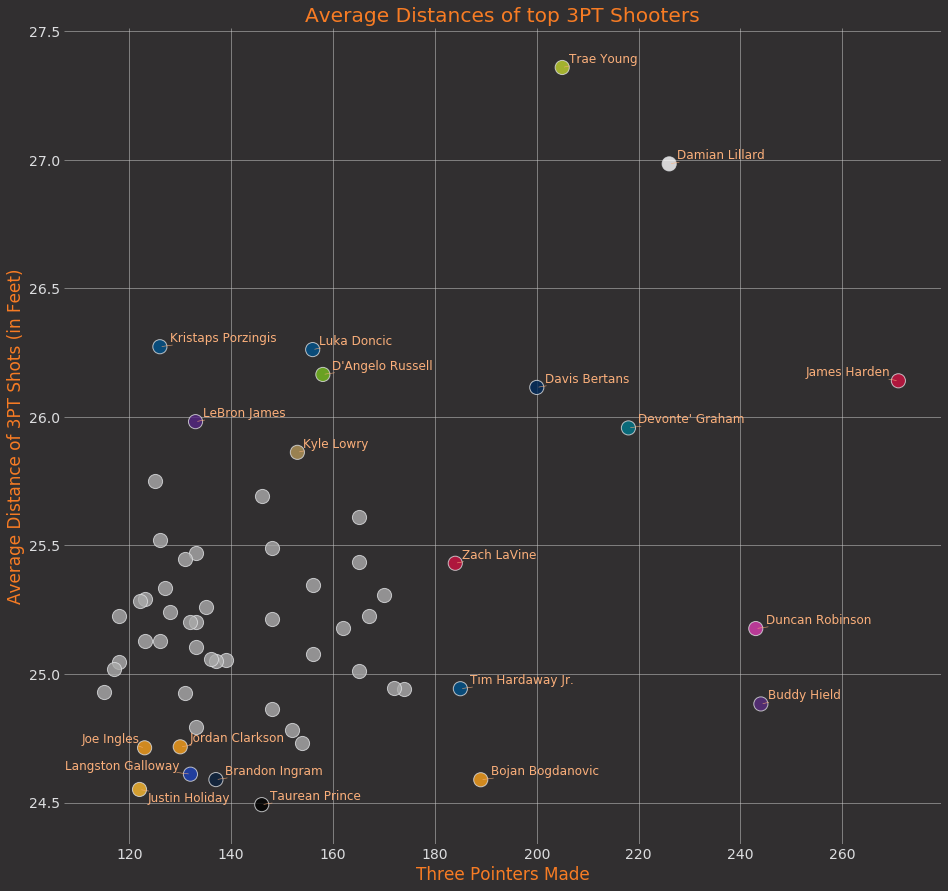

In [26]:
fig, ax = plt.subplots(figsize=(14, 14))

ax.scatter(x=non_marked.FG3M, y=non_marked.MEAN_3PT_DISTANCE, s=200, edgecolors=bball_white, lw=1, color='#ABABAB', alpha=0.8)
ax.scatter(x=all_dfs.FG3M, y=all_dfs.MEAN_3PT_DISTANCE, s=200, edgecolors=bball_white, lw=1, color=colors, alpha=0.8)
ax.set_xlabel("Three Pointers Made", color=bball_orange)
ax.set_ylabel("Average Distance of 3PT Shots (in Feet)", color=bball_orange)
ax.set_title("Average Distances of top 3PT Shooters", color=bball_orange)

ax.set_facecolor(bball_gray)
fig.set_facecolor(bball_gray)
ax.set_frame_on(False)
ticks = ax.get_xticklabels()
for tick in ticks:
    tick.set_color(bball_white)
ticks = ax.get_yticklabels()
for tick in ticks:
    tick.set_color(bball_white)

ax.grid(b=True, alpha=0.5)
texts = []
added = []
for index in range(len(all_dfs)):
    item = all_dfs.iloc[index]
    if item.PLAYER_NAME in added:
        continue
    texts.append(ax.text(x=item.FG3M, y=item.MEAN_3PT_DISTANCE, s=item.PLAYER_NAME, size=12, color=bball_light_orange))
    added.append(item.PLAYER_NAME)
    
adjust_text(texts, arrowprops=dict(arrowstyle='-', color=bball_light_orange), expand_points=(1.2, 1.3))

In [27]:
top_8_shooters = top_three.iloc[:8]

In [28]:
shooters = top_8_shooters.iloc[[0, 2, 3, 5, 7]]

In [29]:
shooters = shooters.sort_values(by='MEAN_3PT_DISTANCE_M', ascending=False)

In [30]:
from math import sqrt, atan, degrees

(-65, 423)

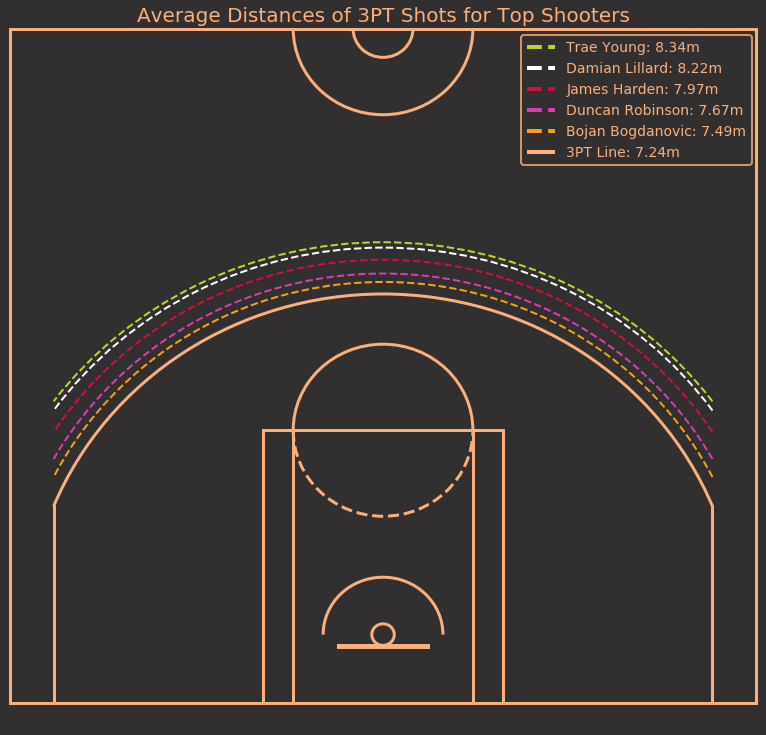

In [31]:
fig, ax = plt.subplots(figsize=(12, 12))

handles = []
labels = []
for index in range(len(shooters)):
    item = shooters.iloc[index]
    radius = item.MEAN_3PT_DISTANCE * 10
    y = sqrt(pow(radius, 2) - pow(220, 2))
    angle = degrees(atan(y / 220.))
    three_arc = Arc((0, 0), radius * 2, radius * 2, theta1=angle, theta2=180 - angle,
                    linewidth=2, ls='--', color=team_colors[item.TEAM_ABBREVIATION])
    labels.append(f"{item.PLAYER_NAME}: {item.MEAN_3PT_DISTANCE_M:.2f}m")
    handles.append(plt.plot([],ls='--', color=team_colors[item.TEAM_ABBREVIATION])[0])
    ax.add_patch(three_arc)
    

labels.append(f"3PT Line: 7.24m")
handles.append(plt.plot([],ls='-', color=bball_light_orange)[0])
#three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
#                    color=color, zorder=0)
#ax = plt.gca()
#ax.add_patch(three_arc)
#arc_patch((0, 0), 26, 22, 158, ax=ax, fill=False, color='#FFFFFF', zorder=10)

ax.set_facecolor(bball_gray)
fig.set_facecolor(bball_gray)
ax.set_frame_on(False)


# Removing ticks
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
#ax.legend()
legend = ax.legend(handles, labels)
frame = legend.get_frame()
frame.set_facecolor(bball_gray)
frame.set_linewidth(2)
frame.set_edgecolor(bball_light_orange)
for text in legend.get_texts():
    text.set_color(bball_light_orange)
ax.grid(False)

# Title
ax.set_title("Average Distances of 3PT Shots for Top Shooters", size=20, color=bball_light_orange)

# Drawing court
draw_court(ax=ax,outer_lines=True, lw=3, color=bball_light_orange)
ax.set_xlim(-251,251)
ax.set_ylim(-65,423)




(-65, 423)

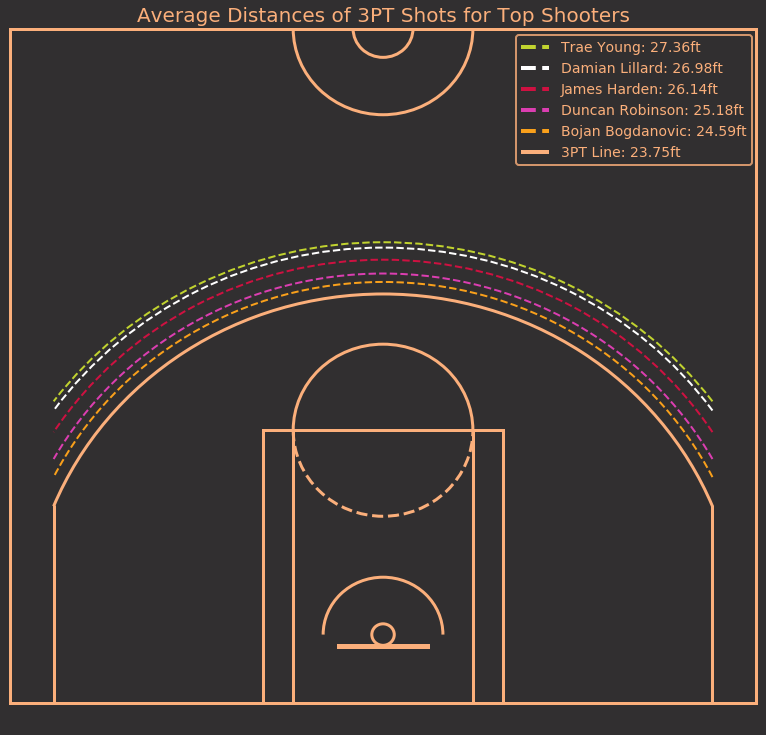

In [34]:
fig, ax = plt.subplots(figsize=(12, 12))

handles = []
labels = []
for index in range(len(shooters)):
    item = shooters.iloc[index]
    radius = item.MEAN_3PT_DISTANCE * 10
    y = sqrt(pow(radius, 2) - pow(220, 2))
    angle = degrees(atan(y / 220.))
    three_arc = Arc((0, 0), radius * 2, radius * 2, theta1=angle, theta2=180 - angle,
                    linewidth=2, ls='--', color=team_colors[item.TEAM_ABBREVIATION])
    labels.append(f"{item.PLAYER_NAME}: {item.MEAN_3PT_DISTANCE:.2f}ft")
    handles.append(plt.plot([],ls='--', color=team_colors[item.TEAM_ABBREVIATION])[0])
    ax.add_patch(three_arc)
    

labels.append(f"3PT Line: 23.75ft")
handles.append(plt.plot([],ls='-', color=bball_light_orange)[0])
#three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
#                    color=color, zorder=0)
#ax = plt.gca()
#ax.add_patch(three_arc)
#arc_patch((0, 0), 26, 22, 158, ax=ax, fill=False, color='#FFFFFF', zorder=10)

ax.set_facecolor(bball_gray)
fig.set_facecolor(bball_gray)
ax.set_frame_on(False)


# Removing ticks
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
#ax.legend()
legend = ax.legend(handles, labels)
frame = legend.get_frame()
frame.set_facecolor(bball_gray)
frame.set_linewidth(2)
frame.set_edgecolor(bball_light_orange)
for text in legend.get_texts():
    text.set_color(bball_light_orange)
ax.grid(False)

# Title
ax.set_title("Average Distances of 3PT Shots for Top Shooters", size=20, color=bball_light_orange)

# Drawing court
draw_court(ax=ax,outer_lines=True, lw=3, color=bball_light_orange)
ax.set_xlim(-251,251)
ax.set_ylim(-65,423)




## PJ Tucker

In [17]:
player_id = find_players_by_full_name("P.J. Tucker")[0]['id']

In [19]:
shotchart = ShotChartDetail(team_id=0, player_id=player_id, season_nullable='2019-20', context_measure_simple='FGA')
shot_df = shotchart.get_data_frames()[0]
shot_df = shot_df.loc[shot_df.SHOT_TYPE == '3PT Field Goal']
shot_df = shot_df.loc[shot_df.SHOT_DISTANCE <= 47]  # only half court shots
mean_dist = shot_df.SHOT_DISTANCE.mean()

In [20]:
mean_dist

23.389105058365757

In [21]:
meter_dist = mean_dist * 0.3048

In [24]:
bball_gray = '#312f30'
bball_white = '#dddee0'
bball_orange = '#f87c24'
bball_light_orange = '#fbaf7b'

In [29]:
from math import sqrt, atan, degrees

(-65, 423)

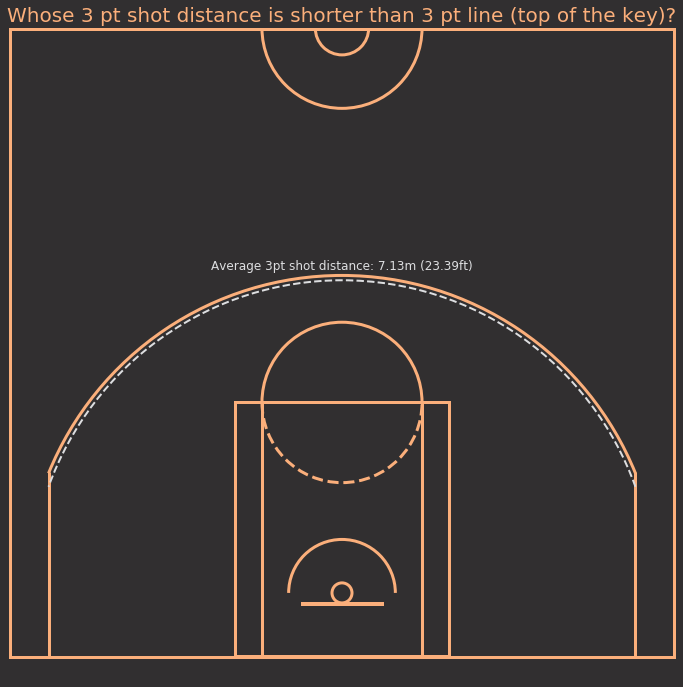

In [39]:
fig, ax = plt.subplots(figsize=(12, 12))

handles = []
labels = []

radius = mean_dist * 10
y = sqrt(pow(radius, 2) - pow(220, 2))
angle = degrees(atan(y / 220.))
three_arc = Arc((0, 0), radius * 2, radius * 2, theta1=angle, theta2=180 - angle,
                linewidth=2, ls='--', color=bball_white)
ax.add_patch(three_arc)
ax.text(x=0, y=242, s=f"Average 3pt shot distance: {meter_dist:.2f}m ({mean_dist:.2f}ft)", ha='center', size=12, color=bball_white)
    

#labels.append(f"3PT Line: 7.24m")
#handles.append(plt.plot([],ls='-', color=bball_light_orange)[0])
#three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
#                    color=color, zorder=0)
#ax = plt.gca()
#ax.add_patch(three_arc)
#arc_patch((0, 0), 26, 22, 158, ax=ax, fill=False, color='#FFFFFF', zorder=10)

ax.set_facecolor(bball_gray)
fig.set_facecolor(bball_gray)
ax.set_frame_on(False)


# Removing ticks
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
ax.grid(False)

# Title
ax.set_title("Whose 3 pt shot distance is shorter than 3 pt line (top of the key)?", size=20, color=bball_light_orange)

# Drawing court
draw_court(ax=ax,outer_lines=True, lw=3, color=bball_light_orange)
ax.set_xlim(-251,251)
ax.set_ylim(-65,423)


